# Beijing Air Quality Forecasting Starter Notebook

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [3]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/beijing_pm2.5_data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/beijing_pm2.5_data/test.csv')


In [17]:
def comment(text):
  description = print("==== " + text + " ====\n" )
  return description

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [5]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [9]:
print("Testing Data Overview:\n")
test.head()

Testing Data Overview:



,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv
0,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,2013-07-02 04:00:00,1.448138,-0.732019,-0.522096
1,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,2013-07-02 05:00:00,1.448138,-0.732019,-0.522096
2,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,2013-07-02 06:00:00,1.448138,-0.732019,-0.522096
3,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,2013-07-02 07:00:00,1.448138,-0.732019,-0.522096
4,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,2013-07-02 08:00:00,1.448138,-0.732019,-0.522096


In [19]:
comment('Shows list of training data columns.\n Now we know that each column has 9 features so this is a multivariate time series\n problem, and each timestep in our sequence will have values from these columns,\n we can assume it will be 9 features per timestep for now')
train.columns

==== Shows list of training data columns.
 Now we know that each column has 9 features so this is a multivariate time series
 problem, and each timestep in our sequence will have values from these columns,
 we can assume it will be 9 features per timestep for now ====



Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

# Dataset Column Definitions:
## **Target Variable**:

**pm2.5**: Fine particulate matter concentration (μg/m³), High values mean more pollution, values above 100μg/m³ are dangerous

## **Features**:

**DEWP**: Dew point temperature (°C) - humidity indicator.

**TEMP**: Air temperature (°C).

**PRES**: Atmospheric pressure (hPa).

**Iws**: Cumulated wind speed (m/s).

**Is**: Cumulated hours of snow


**Ir**: Cumulated hours of rain

**Wind Direction**:

**cbwd_NW**: Northwest wind indicator

**cbwd_SE**: Southeast wind indicator

**cbwd_cv**: Calm/variable wind indicator

In [20]:
comment("Gives a general overview of the dataset including the number of samples,\n number of columns non null entries in each column.\n We can immediately see that there are 30676 entries in the dataset\n and 12 columns total including the index,the target variable and the datetime variable.\n There are no null entries  in any of the columns except the pm2.5 column(our target variable)")
train.info()


==== Gives a general overview of the dataset including the number of samples,
 number of columns non null entries in each column.
 We can immediately see that there are 30676 entries in the dataset
 and 12 columns total including the index,the target variable and the datetime variable.
 There are no null entries  in any of the columns except the pm2.5 column(our target variable) ====

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  floa

In [40]:
comment("Checking for the number of null values in the target variable,\n Checking for missing values helps assess the quality of the data and informs preprocessing strategy, \n we can see that there are 1921 null values in the column")
missing_values  = train['pm2.5'].isnull().sum()

missing_percent = (missing_values/len(train['pm2.5'])) * 100

print (f'The number of missing values in the target column is {missing_values} which is {missing_percent:.2f}% of the records')

==== Checking for the number of null values in the target variable,
 Checking for missing values helps assess the quality of the data and informs preprocessing strategy, 
 we can see that there are 1921 null values in the column ====

The number of missing values in the target column is 1921 which is 6.26% of the records


In [26]:
comment("This block of code ensures that the datetime column is actually in the correct datetime format\n and then shows the range of the dataset\n We can se that the code covers 30675 hours which corresponds to the total number of columns in the dataset\n. This confirms that the records in the dataset are taken an hour apart,\n spanning from 1st of January 2010 to the 2nd of July 2013")

# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Checks the range of the dataset in date(Start date to end date
print(f"Date range is from {train['datetime'].min()} to {train['datetime'].max()}\n")

# Displays the timespan of the dataset in hours
print(f" The total number of hours in the dataset is {(train['datetime'].max() - train['datetime'].min()).total_seconds()/3600} hours")



==== This block of code ensures that the datetime column is actually in the correct datetime format
 and then shows the range of the dataset
 We can se that the code covers 30675 hours which corresponds to the total number of columns in the dataset
. This confirms that the records in the dataset are taken an hour apart,
 spanning from 1st of January 2010 to the 2nd of July 2013 ====

Date range is from 2010-01-01 00:00:00 to 2013-07-02 03:00:00

 The total number of hours in the dataset is 30675.0 hours


In [27]:
# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


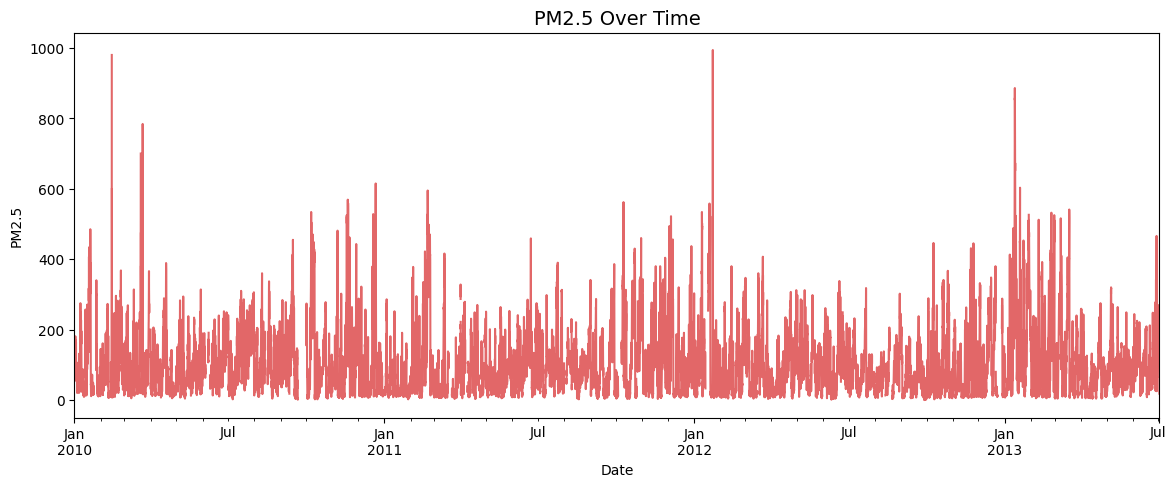

In [30]:
plt.figure(figsize=(14,5))  # (width, height) in inches
train['pm2.5'].plot(color="tab:red", alpha=0.7)
plt.title("PM2.5 Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.show()

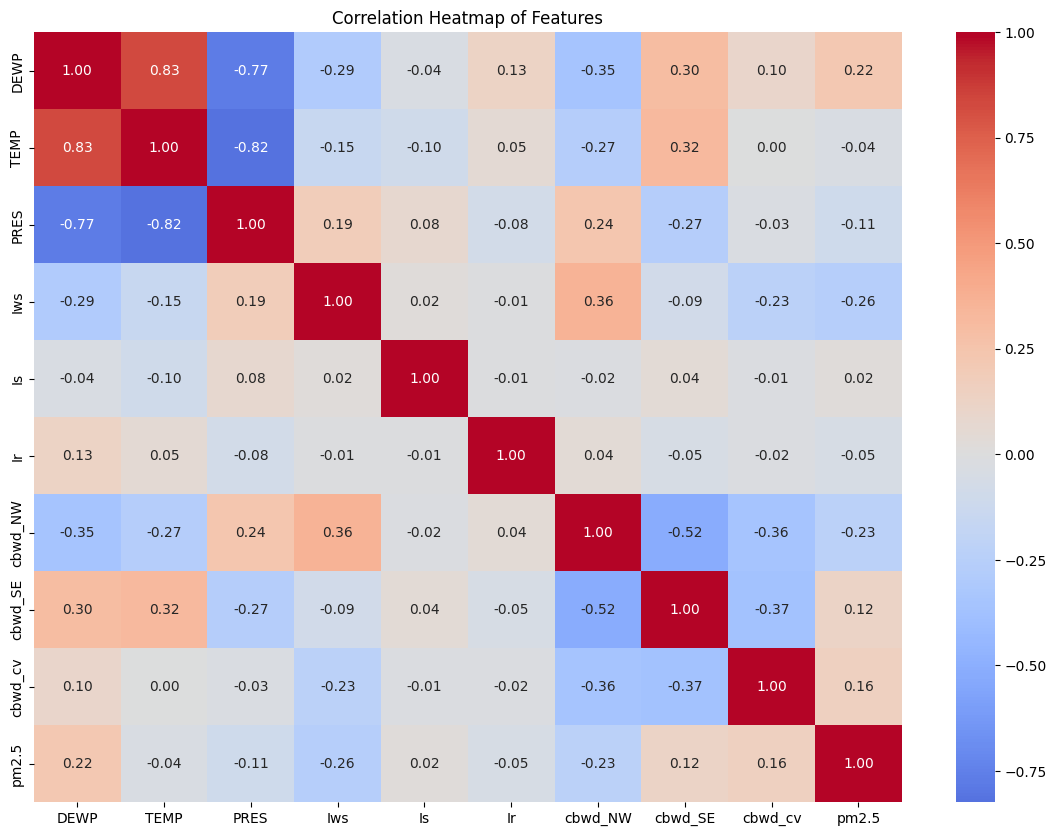

In [37]:
import seaborn as sns
plt.figure(figsize=(14,10))
corr = train.drop(columns=['No']).corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Features")
plt.show()

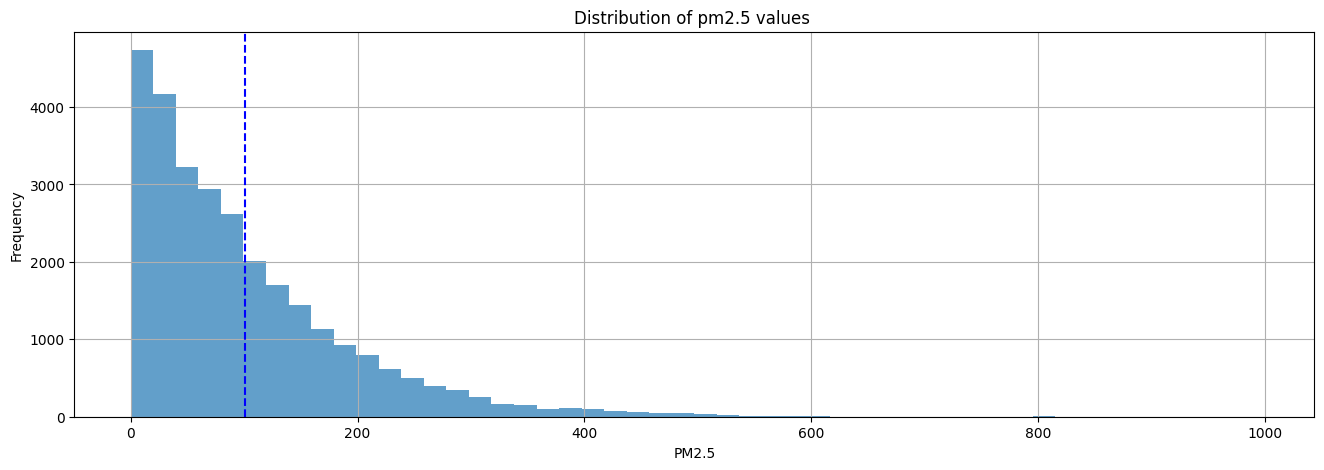

'0-50 μg/m³: Good air quality\n50-100 μg/m³: Moderate pollution\n100+ μg/m³: Unhealthy levels\n\n\n\n'

In [41]:
plt.figure(figsize=(16,5))
train['pm2.5'].dropna().hist(bins=50, color="tab:blue", alpha=0.7)
plt.title("Distribution of pm2.5 values ")
plt.xlabel("PM2.5")
plt.ylabel("Frequency")
plt.axvline(train['pm2.5'].mean(), color='blue', linestyle='--', label='Mean')
plt.show()

"""0-50 μg/m³: Good air quality
50-100 μg/m³: Moderate pollution
100+ μg/m³: Unhealthy levels



"""

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [17]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [8]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [9]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [10]:
# define model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32
)

Epoch 1/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lambda: 69.2472 - loss: 5068.4688
Epoch 2/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 69.2634 - loss: 5079.6426
Epoch 3/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 69.9793 - loss: 5165.9883
Epoch 4/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 68.4694 - loss: 5007.1465
Epoch 5/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - lambda: 70.6989 - loss: 5338.9648
Epoch 6/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 69.2884 - loss: 5054.2236
Epoch 7/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 69.4315 - loss: 5111.6387
Epoch 8/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - lambda: 69.0764 - loss: 5063.5112
Epoch 9/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 69.3577 - loss: 5114.6226
Epoch 10/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 68.7507 - loss: 5034.6899
Epoch 11/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 68.3887 - loss: 4942.9849
Epoch 12/100
907/90

907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


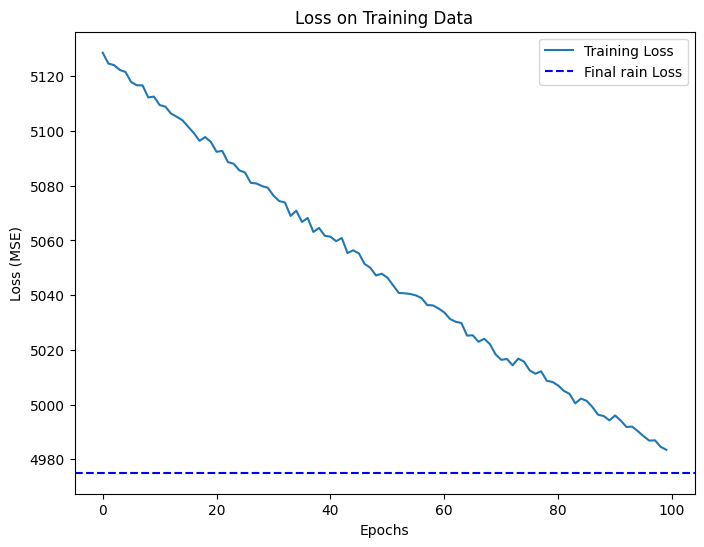

Final Training Loss (MSE): 4975.0774143314065


In [17]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [20]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/beijing_pm2.5_data/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
